In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [2]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EPG_jGCaMP7b_VK05')
sess_df = pd.read_csv(basedir / 'sessions.csv')
sess_df['fly_id'] = [row['date']+'_'+row['fly'] for _, row in sess_df.iterrows()]

In [6]:
stats_df = {'fly_id': [],
           'cl': [],
           'drug': [],
            'corr': [],
           'offset_var':[]}


for _,row in sess_df.iterrows():
    if row['usable']==1:
        outdir = pathlib.PurePath( basedir / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        
        dff = pp.timeseries['rois_z'][0,:,:]-1
        
        heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
        
        x_f,y_f = st2p.utilities.pol2cart(dff ,np.linspace(-np.pi,np.pi,num=dff.shape[0])[:,np.newaxis])
        rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
       
        _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
        
        corr = ast.stats.circcorrcoef(heading,phi)
        
        stats_df['fly_id'].append(row['fly_id'])
        stats_df['cl'].append(row['closed_loop'])
        stats_df['drug'].append(row['drug'])
        stats_df['corr'].append(corr)
        stats_df['offset_var'].append(sp.stats.circvar(offset))
stats_df = pd.DataFrame.from_dict(stats_df)

In [10]:
fly_ids = stats_df['fly_id'].unique()

drug_ids = np.zeros((len(fly_ids),))
for i, fly in enumerate(fly_ids):
    drug_ids[i] = stats_df['drug'].loc[stats_df['fly_id']==fly].iloc[0]

5.0 0.0029526029526029526
29.0 0.331387096247615
10.0 0.011106540518305223
45.0 0.4234471410941999
66.0 0.0024681201151789383


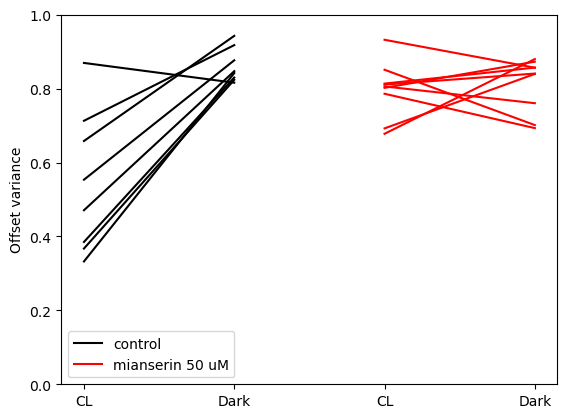

In [50]:
fly_avgs = np.zeros((len(fly_ids),2))
for r, fly in enumerate(fly_ids):
    
    mask = (stats_df['fly_id']==fly)*(stats_df['cl']==1)
    cl = stats_df['offset_var'].loc[mask].mean()
    fly_avgs[r,0]=cl
    
    mask = (stats_df['fly_id']==fly)*(stats_df['cl']==0)
    dark = stats_df['offset_var'].loc[mask].mean()
    fly_avgs[r,1] = dark
    

fig,ax = plt.subplots()
c_h = ax.plot([0,1],fly_avgs[drug_ids==0,:].T, color='black', label='Control')


d_h = ax.plot([2,3],fly_avgs[drug_ids==1,:].T, color='red', label='Mianserin 50 uM')

t,p = sp.stats.mannwhitneyu(fly_avgs[drug_ids==0,0], fly_avgs[drug_ids==0,1])
print(t,p)

t,p = sp.stats.mannwhitneyu(fly_avgs[drug_ids==1,0], fly_avgs[drug_ids==1,1])
print(t,p)

t,p = sp.stats.mannwhitneyu(fly_avgs[drug_ids==0,0], fly_avgs[drug_ids==1,0])
print(t,p)

t,p = sp.stats.mannwhitneyu(fly_avgs[drug_ids==0,1], fly_avgs[drug_ids==1,1])
print(t,p)

diff = fly_avgs[:,1]-fly_avgs[:,0]
t,p = sp.stats.mannwhitneyu(diff[drug_ids==0], diff[drug_ids==1])
print(t,p)

ax.set_ylim([0,1])
ax.set_xticks([0, 1, 2, 3], labels=['CL', 'Dark', 'CL', 'Dark'])
ax.set_ylabel('Offset variance')
ax.legend([c_h[0],d_h[0]], ['control', 'mianserin 50 uM'])

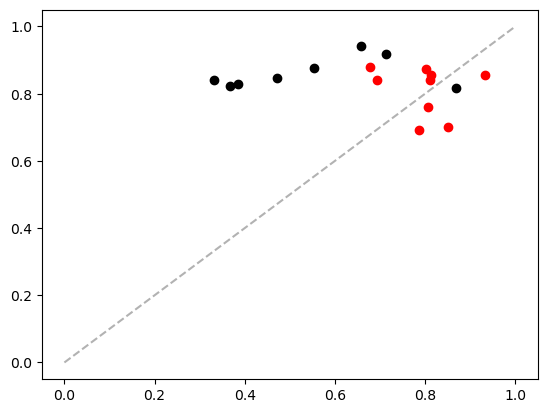

In [48]:
fig, ax = plt.subplots()
ax.scatter(fly_avgs[drug_ids==0,0], fly_avgs[drug_ids==0,1], c='black')
ax.scatter(fly_avgs[drug_ids==1,0], fly_avgs[drug_ids==1,1], c='red')
ax.plot([0,1],[0,1],'k--', alpha=.3, zorder=-1)

3.5232075182972893 0.003375888517446638
2.099563066685332 0.05198393225343568
2.144270537187633 0.04880171278069551
-0.021384925529521797 0.9832204778441256
-2.1045605278467936 0.0526018011239095


Text(0, 0.5, 'Phase-Heading Corr')

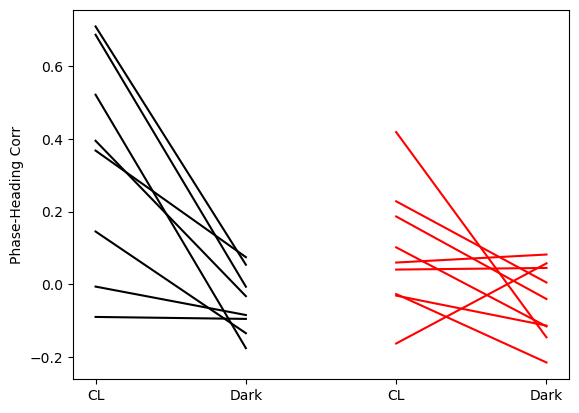

In [53]:
fly_avgs = np.zeros((len(fly_ids),2))
for r, fly in enumerate(fly_ids):
    
    mask = (stats_df['fly_id']==fly)*(stats_df['cl']==1)
    cl = stats_df['corr'].loc[mask].mean()
    fly_avgs[r,0]=cl
    
    mask = (stats_df['fly_id']==fly)*(stats_df['cl']==0)
    dark = stats_df['corr'].loc[mask].mean()
    fly_avgs[r,1] = dark
    
fly_avgs = np.arctanh(fly_avgs)

fig,ax = plt.subplots()
c_h = ax.plot([0,1],fly_avgs[drug_ids==0,:].T, color='black', label='Control')


d_h = ax.plot([2,3],fly_avgs[drug_ids==1,:].T, color='red', label='Mianserin 50 uM')

t,p = sp.stats.ttest_ind(fly_avgs[drug_ids==0,0], fly_avgs[drug_ids==0,1])
print(t,p)

t,p = sp.stats.ttest_ind(fly_avgs[drug_ids==1,0], fly_avgs[drug_ids==1,1])
print(t,p)

t,p = sp.stats.ttest_ind(fly_avgs[drug_ids==0,0], fly_avgs[drug_ids==1,0])
print(t,p)

t,p = sp.stats.ttest_ind(fly_avgs[drug_ids==0,1], fly_avgs[drug_ids==1,1])
print(t,p)

diff = fly_avgs[:,1]-fly_avgs[:,0]
t,p = sp.stats.ttest_ind(diff[drug_ids==0], diff[drug_ids==1])
print(t,p)

# ax.set_ylim([0,1])
ax.set_xticks([0, 1, 2, 3], labels=['CL', 'Dark', 'CL', 'Dark'])
ax.set_ylabel('Phase-Heading Corr')
# ax.legend([c_h[0],d_h[0]], ['control', 'mianserin 50 uM'])